In [450]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.display import display

from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup

In [451]:
df = pd.read_csv("../data/kershaw.csv")
df['year'] = pd.DatetimeIndex(df['game_date']).year  # separate year from date
df['month'] = pd.DatetimeIndex(df['game_date']).month
df_2008 = df[df['year']==2008]
df_2017_season = df[(df['year']==2017) & (df['month'] >= 4)]

/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_70074/806051061.py:1: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/kershaw.csv")


In [452]:
states = {(0,0): 0,
          (1,0): 1,
          (2,0): 2,
          (3,0): 3,
          (0,1): 4,
          (0,2): 5,
          (1,1): 6,
          (1,2): 7,
          (2,1): 8,
          (2,2): 9,
          (3,1): 10,
          (3,2): 11,
          "Out": 12, 
          "Single": 13, 
          "Double": 14, 
          "Triple": 15, 
          "HR": 16, 
          "Walk": 17}
pitch_count_labels = [
    "(0,0)",
    "(1,0)",
    "(2,0)",
    "(3,0)",
    "(0,1)",
    "(0,2)",
    "(1,1)",
    "(1,2)",
    "(2,1)",
    "(2,2)",
    "(3,1)",
    "(3,2)",
    "Out", 
    "Single",
    "Double",
    "Triple",
    "HR",
    "Walk"
]

In [453]:
df_simple = df_2017_season.filter(items=['balls',
                             'strikes',
                             'events',
                             'description',
                             'game_date'])
df_simple = df_simple.iloc[::-1] # reverse order from earliest to latest
non_terminal_states = list(zip(df_simple.balls, df_simple.strikes))
df_simple['non_terminal_states'] = non_terminal_states
df_simple = df_simple.reset_index()

#create unique list of names
unique_games = df_simple.game_date.unique()
DataFrameDict = {elem : pd.DataFrame() for elem in unique_games}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_simple[:][df_simple.game_date == key]

In [506]:
def get_pitch_sequence(df_game):
    pitch_seq = []
    action_seq = []
    walk_flag = False
    for i, row in df_game.iterrows():
        event = row['events']

        # no outcome, add non-terminal state
        if str(event) == "nan" or str(event) == "field_error" or str(event) == "fielders_choice":
            pitch_seq.append(states[row['non_terminal_states']])
        # if Out, add terminal state
        elif (str(event) == "strikeout" or 
                str(event) == "field_out" or 
                str(event) == "grounded_into_double_play" or 
                str(event) == "fielders_choice_out" or 
                str(event) == "sac_fly" or 
                str(event) == "force_out" or 
                str(event) == "sac_bunt" or 
                str(event) == "caught_stealing_2b" or 
                str(event) == "double_play"):
            pitch_seq.append(states["Out"])
        elif (str(event) == "single"):
            pitch_seq.append(states["Single"])
        elif (str(event) == "double"):
            pitch_seq.append(states["Double"])
        elif (str(event) == "triple"):
            pitch_seq.append(states["Triple"])
        elif (str(event) == "home_run"):
            pitch_seq.append(states["HR"])
        elif (str(event) == "walk"):
            pitch_seq.append(states[row['non_terminal_states']])
            pitch_seq.append(states["Walk"])
            walk_flag = True

        # if swing
        if (row['description'] == 'foul' or 
             row['description'] == 'swinging_strike' or 
             row['description'] == 'foul_tip' or
             row['description'] == 'swinging_strike_blocked' or
             row['description'] == 'foul_bunt' or 
             row['description'] == 'missed_bunt' or 
             row['description'] == 'hit_into_play'):
            # action_seq.append("swing")
            action_seq.append(1)
        # elif stand
        elif (row['description'] == 'called_strike' or 
              row['description'] == 'ball' or 
              row['description'] == 'blocked_ball'):
            # action_seq.append("stand")
                action_seq.append(0)
                if walk_flag:
                    # action_seq.append("stand")
                    action_seq.append(0)
                    walk_flag = False
    return pitch_seq, action_seq

In [507]:
pitch_seq, action_seq = get_pitch_sequence(df_simple)
pitch_seq_df = pd.DataFrame({'state': pitch_seq,
                             'action': action_seq})

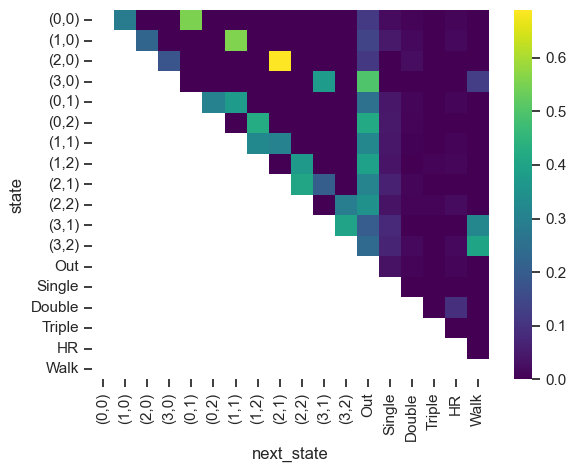

In [419]:
# Sample DataFrame with a 'state' column
data = {'state': pitch_seq}
df = pd.DataFrame(data)

# Create a new column 'next_state' that represents the next state for each row
df['next_state'] = df['state'].shift(-1)

# Remove the last row since it doesn't have a next state
df = df[:-1]

# Calculate transition counts
transition_counts = df.groupby(['state', 'next_state']).size().unstack(fill_value=0)

# Calculate transition probabilities
transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

mask = np.tril(np.ones_like(transition_probabilities))
sns.heatmap(transition_probabilities, 
            cmap='viridis', 
            cbar=True,
            fmt='.2f',
            mask=mask,
            xticklabels=pitch_count_labels,
            yticklabels=pitch_count_labels)
plt.show()

In [598]:
# Sample DataFrame with 'state' and 'label' columns
data = {'state': pitch_seq,
		'action': action_seq}
df = pd.DataFrame(data)
# # Create new columns 'next_state' and 'next_label' representing the next state and label for each row
df['next_state'] = df['state'].shift(-1)

transition_matrix = np.zeros((13, 18, 2))

for i, row in df.iterrows():
	current_state = int(row['state'])
	action = int(row['action'])
	if math.isnan(row['next_state']) or current_state >= 12:
		continue
	next_state = int(row['next_state'])
	transition_matrix[current_state, next_state, action] += int(1)
for row in transition_matrix[:,:,0]: print(' '.join('{}'.format(x) for x in row))
print()
for row in transition_matrix[:,:,1]: print(' '.join('{}'.format(x) for x in row))

0.0 202.0 0.0 0.0 217.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 55.0 12.0 3.0 0.0 5.0 0.0
0.0 0.0 45.0 0.0 0.0 0.0 35.0 0.0 0.0 0.0 0.0 0.0 15.0 6.0 2.0 0.0 3.0 0.0
0.0 0.0 0.0 8.0 0.0 0.0 0.0 0.0 9.0 0.0 0.0 0.0 2.0 0.0 1.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 4.0 0.0 0.0 0.0 0.0 1.0
0.0 0.0 0.0 0.0 0.0 43.0 146.0 0.0 0.0 0.0 0.0 0.0 57.0 12.0 2.0 0.0 3.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 56.0 0.0 0.0 0.0 0.0 38.0 4.0 1.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 19.0 78.0 0.0 0.0 0.0 36.0 8.0 0.0 0.0 2.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 63.0 0.0 0.0 45.0 6.0 0.0 0.0 1.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.0 22.0 0.0 9.0 2.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 43.0 33.0 1.0 1.0 1.0 2.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.0 2.0 1.0 0.0 0.0 0.0 8.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 29.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

2.0 0.0 0.0 0.0 172.0 0.0 0.0 0.0 0.0 

In [603]:
for row in transition_matrix[:,:,0]:
    n = sum(row)
    if n > 0:
        row[:] = [f/sum(row) for f in row]

for row in transition_matrix[:,:,1]:
    n = sum(row)
    if n > 0:
        row[:] = [f/sum(row) for f in row]

for row in transition_matrix[:,:,0]: print(' '.join('{:.2f}'.format(x) for x in row))
print()
for row in transition_matrix[:,:,1]: print(' '.join('{:.2f}'.format(x) for x in row))

0.00 0.41 0.00 0.00 0.44 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.11 0.02 0.01 0.00 0.01 0.00
0.00 0.00 0.42 0.00 0.00 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.14 0.06 0.02 0.00 0.03 0.00
0.00 0.00 0.00 0.40 0.00 0.00 0.00 0.00 0.45 0.00 0.00 0.00 0.10 0.00 0.05 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.29 0.00 0.57 0.00 0.00 0.00 0.00 0.14
0.00 0.00 0.00 0.00 0.00 0.16 0.56 0.00 0.00 0.00 0.00 0.00 0.22 0.05 0.01 0.00 0.01 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.57 0.00 0.00 0.00 0.00 0.38 0.04 0.01 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.13 0.55 0.00 0.00 0.00 0.25 0.06 0.00 0.00 0.01 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.55 0.00 0.00 0.39 0.05 0.00 0.00 0.01 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.20 0.54 0.00 0.22 0.05 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.53 0.41 0.01 0.01 0.01 0.02 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.27 0.13 0.07 0.00 0.00 0.00 0.53
0.00 0.00 

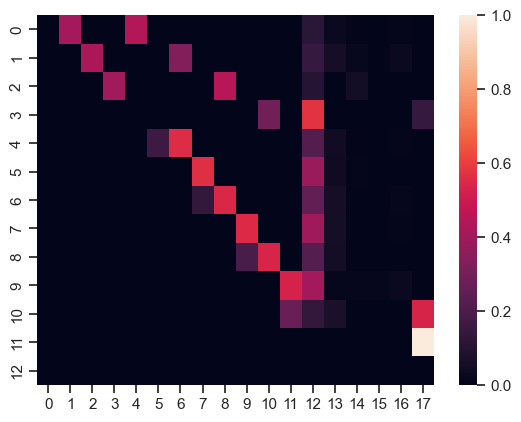

In [604]:
sns.heatmap(transition_matrix[:,:,0])
plt.show()

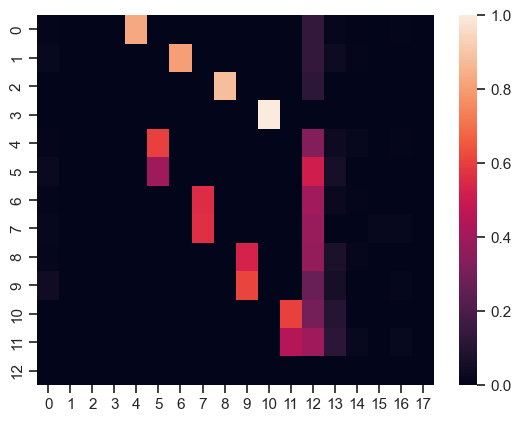

In [605]:
sns.heatmap(transition_matrix[:,:,1])
plt.show()

/Users/oliverchang/opt/anaconda3/envs/stats/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


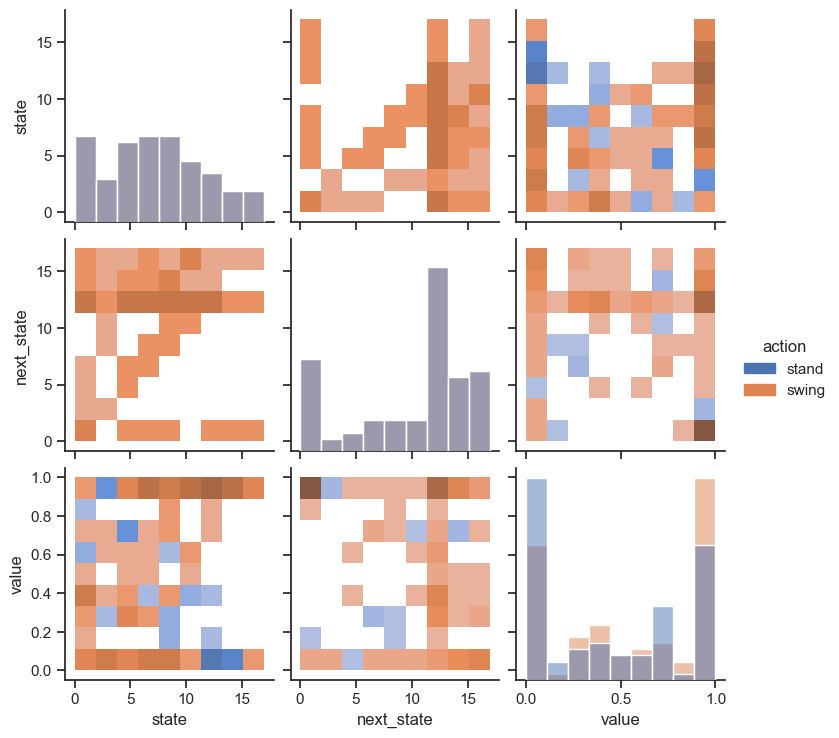

In [409]:
sns.pairplot(transition_probabilities, hue="action", kind="hist")

/Users/oliverchang/opt/anaconda3/envs/stats/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


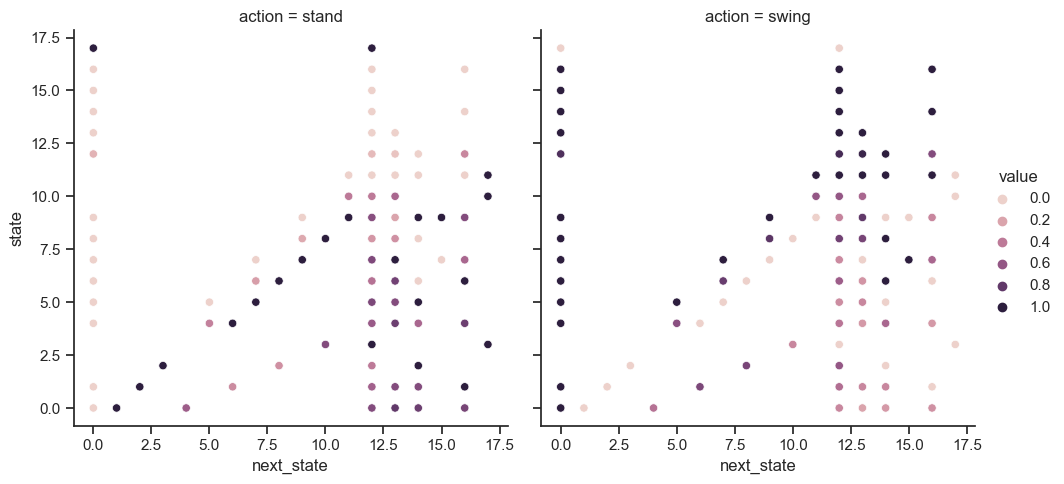

In [405]:
sns.relplot(
    data=transition_probabilities, x="next_state", y="state",
    col="action", hue="value",
    kind="scatter"
)

<Axes: xlabel='action', ylabel='state-next_state'>

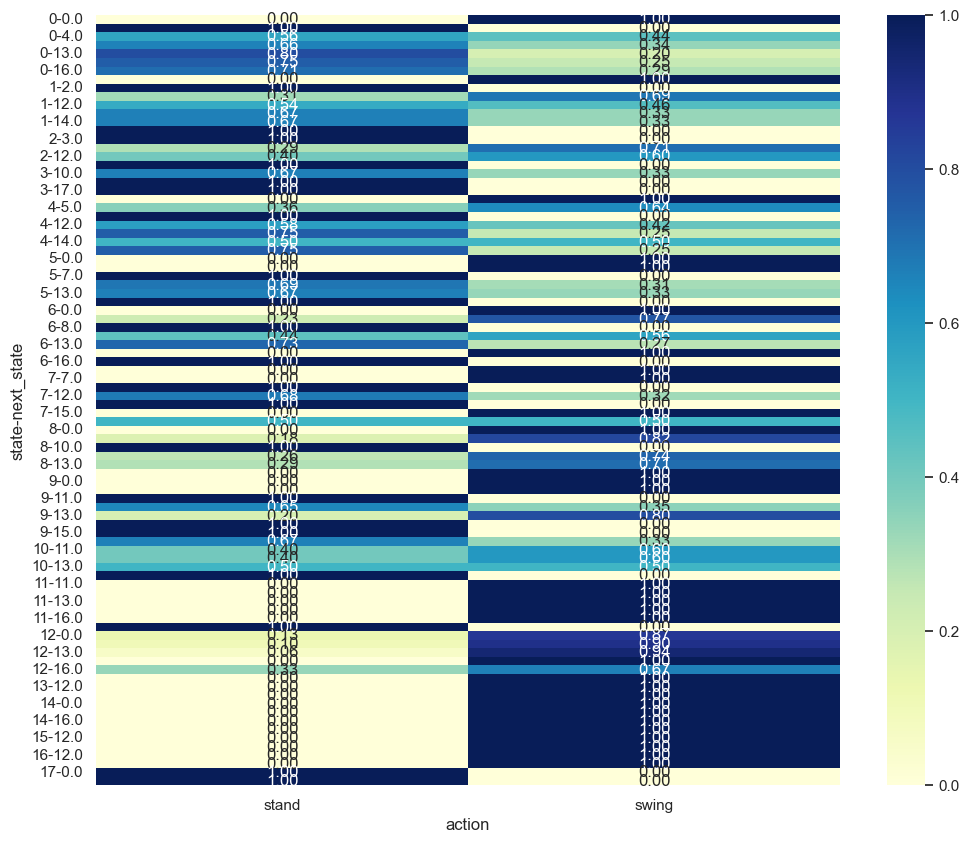

In [368]:
plt.figure(figsize=(12, 10))
sns.heatmap(transition_probabilities, annot=True, cmap="YlGnBu", fmt=".2f")

In [381]:
sns.set(style='ticks') 
np.random.seed(0)

groups = ('Group 1', 'Group 2')
sexes = ('Male', 'Female')
means = ('Low', 'High')
index = pd.MultiIndex.from_product(
    [groups, sexes, means], 
   names=['Group', 'Sex', 'Mean']
)

values = np.random.randint(low=20, high=100, size=len(index))
data = pd.DataFrame(data={'val': values}, index=index) # .reset_index()
# print(data)

# fg = sns.catplot(x='Group', y='val', hue='Mean', 
#                         col='Sex', data=data, kind='bar')
# fg.set_xlabels('')
data

val
Group   Sex    Mean     
Group 1 Male   Low    64
               High   67
        Female Low    84
               High   87
Group 2 Male   Low    87
               High   29
        Female Low    41
               High   56

next_label              stand  swing
state next_state label              
A     A          stand    0.0    1.0
      B          swing    1.0    0.0
      C          swing    0.5    0.5
B     A          stand    0.0    1.0
                 swing    1.0    0.0
      C          stand    0.0    1.0
C     B          stand    0.0    1.0
                 swing    1.0    0.0


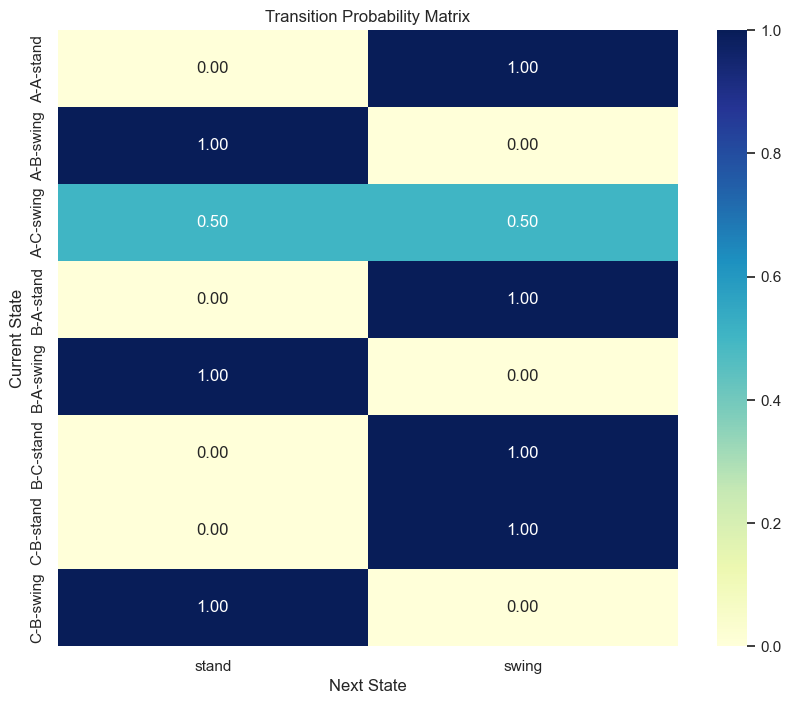

In [353]:
import pandas as pd

# Sample DataFrame with 'state' and 'label' columns
data = {'state': ['A', 'B', 'A', 'C', 'B', 'A', 'A', 'C', 'B', 'C'],
        'label': ['swing', 'stand', 'swing', 'stand', 'swing', 'stand', 'swing', 'swing', 'stand', 'swing']}
df = pd.DataFrame(data)

# Create new columns 'next_state' and 'next_label' representing the next state and label for each row
df['next_state'] = df['state'].shift(-1)
df['next_label'] = df['label'].shift(-1)

# Remove the last row since it doesn't have a next state or label
df = df[:-1]

# Calculate transition counts for state and label combinations
transition_counts = df.groupby(['state', 'next_state', 'label', 'next_label']).size().unstack(fill_value=0)

# Calculate transition probabilities for both "swing" and "stand" labels
transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

print(transition_probabilities)

# Set the plot style (optional)
sns.set(style="whitegrid")

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(transition_probabilities, annot=True, cmap="YlGnBu", fmt=".2f")

# Set axis labels and title
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.title("Transition Probability Matrix")

# Show the plot
plt.show()

In [ ]:
M_swing = pd.DataFrame(M_swing)
M_swing = M_swing.rename(columns={
                  0:"(0,0)",
                  1:"(1,0)",
                  2:"(2,0)",
                  3:"(3,0)",
                  4:"(0,1)",
                  5:"(0,2)",
                  6:"(1,1)",
                  7:"(1,2)",
                  8:"(2,1)",
                  9:"(2,2)",
                  10:"(3,1)",
                  11:"(3,2)"})
M_stand = pd.DataFrame(M_stand)
M_stand = M_stand.rename(columns={
                  0:"(0,0)",
                  1:"(1,0)",
                  2:"(2,0)",
                  3:"(3,0)",
                  4:"(0,1)",
                  5:"(0,2)",
                  8:"(2,1)",
                  6:"(1,1)",
                  7:"(1,2)",
                  9:"(2,2)",
                  10:"(3,1)",
                  11:"(3,2)"})

In [272]:
def count_transitions(pitch_seq):
    n = 1+ max(pitch_seq) #number of states
    M = [[0]*n for _ in range(n)]
    for (i,j) in zip(pitch_seq,pitch_seq[1:]):
        M[i][j] += 1
    return np.array(M)

In [207]:
def get_probabilities(m):
    for row in m:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return m

In [186]:
all_swing_matrices = []
all_stand_matrices = []

for game_date, game_df in DataFrameDict.items():
    pitch_sequence_swing, pitch_sequence_stand = get_pitch_sequence(game_df)

    m_swing = count_transitions(pitch_sequence_swing)
    m_stand = count_transitions(pitch_sequence_stand)

    pad_len_swing = 18 - len(m_swing)
    pad_len_stand = 18 - len(m_stand)

    m_swing = np.pad(m_swing, (0, pad_len_swing), mode="constant")
    m_stand = np.pad(m_stand, (0, pad_len_stand), mode="constant")

    all_swing_matrices.append(m_swing)
    all_stand_matrices.append(m_stand)
    break

all_swing_matrices = np.array(all_swing_matrices)
all_stand_matrices = np.array(all_stand_matrices) 

M_swing = sum(all_swing_matrices)
M_stand = sum(all_stand_matrices)

M_swing = get_probabilities(M_swing.tolist())
M_stand = get_probabilities(M_stand.tolist())

M_swing = np.array(M_swing)
M_stand = np.array(M_stand)

print("Pitch transition probability under swing")
for row in M_swing: print(' '.join('{0:.2f}'.format(x) for x in row))
print("")
print("Pitch transition probability under stand")
for row in M_stand: print(' '.join('{0:.2f}'.format(x) for x in row))

Pitch transition probability under swing
0.25 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.25 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.40 0.00 0.00 0.00 0.00 0.00 0.60 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.25 0.00 0.00 0.00 0.00 0.25 0.00 0.25 0.00 0.00 0.00 0.00 0.25 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.75 0.25 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.50 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00

In [191]:
df_simple[df_simple['game_date'] == '2017-04-03'].head(50)

,index,balls,strikes,events,description,game_date,non_terminal_states
0,29771,0,0,NaN,called_strike,2017-04-03,"(0, 0)"
1,29770,0,1,NaN,foul,2017-04-03,"(0, 1)"
2,29769,0,2,NaN,ball,2017-04-03,"(0, 2)"
3,29768,1,2,strikeout,swinging_strike,2017-04-03,"(1, 2)"
4,29767,0,0,NaN,ball,2017-04-03,"(0, 0)"
5,29766,1,0,NaN,swinging_strike,2017-04-03,"(1, 0)"
6,29765,1,1,NaN,swinging_strike,2017-04-03,"(1, 1)"
7,29764,1,2,field_error,hit_into_play,2017-04-03,"(1, 2)"
8,29763,0,0,NaN,ball,2017-04-03,"(0, 0)"
9,29762,1,0,NaN,blocked_ball,2017-04-03,"(1, 0)"


In [192]:
df_simple[df_simple['game_date'] == '2017-04-03'].tail(50)

,index,balls,strikes,events,description,game_date,non_terminal_states
34,29737,3,2,field_out,hit_into_play,2017-04-03,"(3, 2)"
35,29736,0,0,NaN,foul,2017-04-03,"(0, 0)"
36,29735,0,1,NaN,foul,2017-04-03,"(0, 1)"
37,29734,0,2,NaN,ball,2017-04-03,"(0, 2)"
38,29733,1,2,NaN,foul,2017-04-03,"(1, 2)"
39,29732,1,2,NaN,foul,2017-04-03,"(1, 2)"
40,29731,1,2,NaN,foul,2017-04-03,"(1, 2)"
41,29730,1,2,NaN,foul,2017-04-03,"(1, 2)"
42,29729,1,2,strikeout,called_strike,2017-04-03,"(1, 2)"
43,29728,0,0,NaN,called_strike,2017-04-03,"(0, 0)"


## Visualization

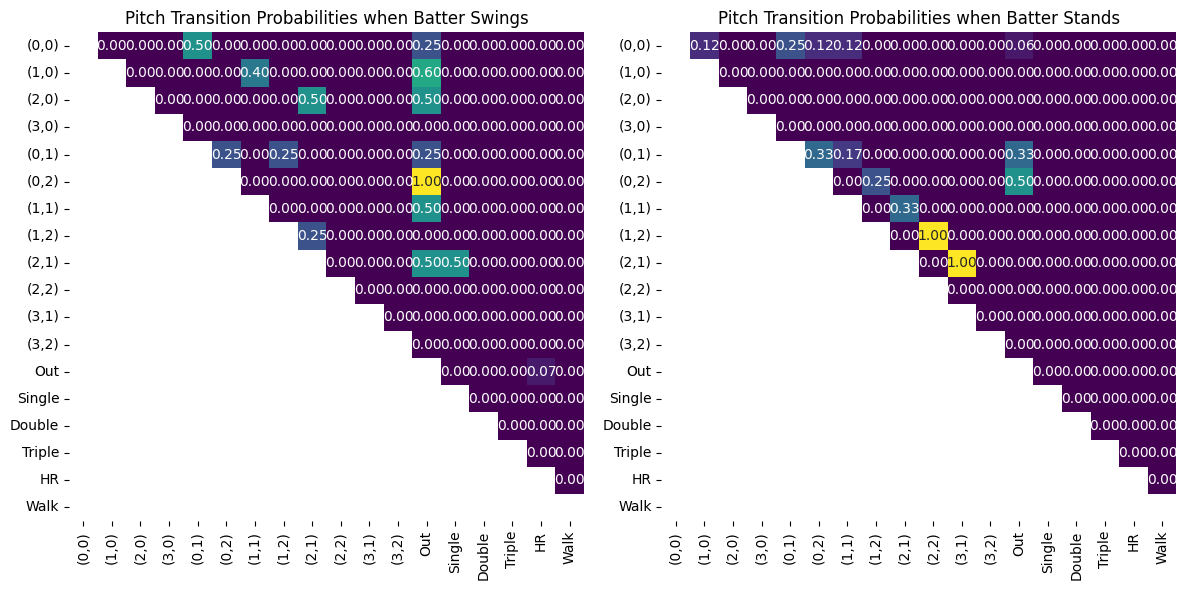

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for the two heatmaps

matrix = np.tril(np.ones_like(M_swing))

# Plot the first heatmap (array1)
sns.heatmap(M_swing, 
            ax=axes[0], 
            cmap='viridis', 
            annot=True, 
            fmt='.2f', 
            cbar=False, 
            mask=matrix,
            xticklabels=pitch_count_labels,
            yticklabels=pitch_count_labels)
axes[0].set_title('Pitch Transition Probabilities when Batter Swings')

# Plot the second heatmap (array2)
sns.heatmap(M_stand, 
            ax=axes[1], 
            cmap='viridis', 
            annot=True, 
            fmt='.2f', 
            cbar=False, 
            mask=matrix,
            xticklabels=pitch_count_labels,
            yticklabels=pitch_count_labels)
axes[1].set_title('Pitch Transition Probabilities when Batter Stands')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()  

In [449]:
for a in ['stand', 'swing']:
    print(a)

stand
swing
